# Data preprocessing

## Understanding the Problem Statement

Customer reviews can often be long and descriptive. Analyzing these reviews manually, as you can imagine, is really time-consuming. This is where the brilliance of Natural Language Processing can be applied to generate a summary for long reviews.

We will be working on a really cool dataset. Our objective here is to generate a summary for the Amazon Fine Food reviews using the abstraction-based approach we learned about above. You can download the dataset from[ here ](https://www.kaggle.com/snap/amazon-fine-food-reviews)

It’s time to fire up our Jupyter notebooks! Let’s dive into the implementation details right away.


### Import the libraries

In [1]:
import numpy as np
import pandas as pd 
import re
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# For the first time you need to install beautifulsoup4
#!pip install --user beautifulsoup4

from bs4 import BeautifulSoup

In [3]:
# Copy datafiles from GS
import os, shutil
DATADIR='data'
os.environ['DATA'] = DATADIR

shutil.rmtree(DATADIR, ignore_errors=True)
os.makedirs(DATADIR)

#Copy datafile from GS bucket
#!gsutil cp gs://mlend_text_summarization/data/amazon-fine-food-reviews/Reviews_mini.csv ${DATADIR}

In [4]:
%%bash
gsutil cp gs://mlend_text_summarization/data/amazon-fine-food-reviews/Reviews_mini.csv ${DATA}

Copying gs://mlend_text_summarization/data/amazon-fine-food-reviews/Reviews_mini.csv...
- [1 files][ 48.9 MiB/ 48.9 MiB]                                                
Operation completed over 1 objects/48.9 MiB.                                     


## Load the data

In [5]:
data=pd.read_csv("data/Reviews_mini.csv",nrows=5000)

In [6]:
data.drop_duplicates(subset=['Text'],inplace=True)#dropping duplicates
data.dropna(axis=0,inplace=True)#dropping na

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959 entries, 0 to 4998
Data columns (total 10 columns):
Id                        959 non-null object
ProductId                 959 non-null object
UserId                    959 non-null object
ProfileName               959 non-null object
HelpfulnessNumerator      959 non-null float64
HelpfulnessDenominator    959 non-null float64
Score                     959 non-null float64
Time                      959 non-null float64
Summary                   959 non-null object
Text                      959 non-null object
dtypes: float64(4), object(6)
memory usage: 82.4+ KB


## Preprocessing

Performing basic preprocessing steps is very important before we get to the model building part. Using messy and uncleaned text data is a potentially disastrous move. So in this step, we will drop all the unwanted symbols, characters, etc. from the text that do not affect the objective of our problem.

Here is the dictionary that we will use for expanding the contractions:

In [8]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [9]:
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Cleaning and preprocessing the dataset

In [10]:
#call the function
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [11]:
cleaned_text[:5]

['bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better',
 'looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal',
 'right mostly sprouting cats eat grass love rotate around wheatgrass rye',
 'healthy dog food good digestion also good small puppies dog eats required amount every feeding',
 'love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating']

In [12]:
#call the function
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [13]:
cleaned_summary[:10]

['good quality dog food',
 'cough medicine',
 'yay barley',
 'healthy dog food',
 'poor taste',
 'love it',
 'home delivered twizlers',
 'delicious product',
 'twizzlers',
 'great bargain for the price']

In [14]:
data['cleaned_text']=cleaned_text
data['cleaned_summary']=cleaned_summary

### Drop empty rows

In [15]:
data.replace('', np.nan, inplace=True)
data.dropna(axis=0,inplace=True)

#Understanding the distribution of the sequences

Here, we will analyze the length of the reviews and the summary to get an overall idea about the distribution of length of the text. This will help us fix the maximum length of the sequence:

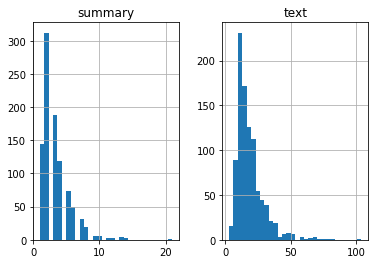

In [16]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 30)
plt.show()

Interesting. We can fix the maximum length of the summary to 8 since that seems to be the majority summary length.

Let us understand the proportion of the length of summaries below 8

In [18]:
summary_length=10
cnt=0
for i in data['cleaned_summary']:
    if(len(i.split())<=summary_length):
        cnt=cnt+1
print(cnt/len(data['cleaned_summary']))

0.9874869655891554


We observe that 94% of the summaries have length below 8. So, we can fix maximum length of summary to 8.

Let us fix the maximum length of review to 30

In [19]:
max_text_len=40
max_summary_len=10

Let us select the reviews and summaries whose length falls below or equal to **max_text_len** and **max_summary_len**

In [20]:
cleaned_text =np.array(data['cleaned_text'])
cleaned_summary=np.array(data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
df=pd.DataFrame({'text':short_text,'summary':short_summary})

In [21]:
df.head(5)

,summary,text
0,good quality dog food,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
1,cough medicine,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
2,yay barley,right mostly sprouting cats eat grass love rotate around wheatgrass rye
3,healthy dog food,healthy dog food good digestion also good small puppies dog eats required amount every feeding
4,poor taste,love eating good watching tv looking movies sweet like transfer zip lock baggie stay fresh take time eating


## Save the data preprocessed and cleaned
Create a file for training and a file for evaluation 

In [29]:
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head(10)
print('Lenth dataset: ',len(df))

Lenth dataset:  914


In [31]:
training_size = int(len(df)*0.85)
print(training_size)
df.iloc[:training_size,:].to_csv('data/train.csv',sep=',')
df.iloc[training_size:,:].to_csv('data/validation.csv',sep=',')

776


Save the train and validation dataset to GS

In [32]:
%%bash
gsutil cp data/train.csv gs://mlend_text_summarization/data/amazon-fine-food-reviews
gsutil cp data/validation.csv gs://mlend_text_summarization/data/amazon-fine-food-reviews

Copying file://data/train.csv [Content-Type=text/csv]...
/ [1 files][103.4 KiB/103.4 KiB]                                                
Operation completed over 1 objects/103.4 KiB.                                    
Copying file://data/validation.csv [Content-Type=text/csv]...
/ [1 files][ 17.5 KiB/ 17.5 KiB]                                                
Operation completed over 1 objects/17.5 KiB.                                     
